In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score
from umap import UMAP

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
from cassava.transforms import get_test_transforms
from cassava.utils import make_confusion_matrix, plot_image, Unnormalize

In [22]:
%matplotlib inline

In [23]:
# metrics = context.catalog.load('train_metrics')

In [24]:
# metrics['last_epoch']

In [25]:
# plt.figure()
# sns.lineplot(data=metrics['train_losses'], label='train_loss')
# plt.show()

# plt.figure()
# sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
# plt.show()

In [26]:
# train_indices, val_indices = context.catalog.load('train_indices'), context.catalog.load('val_indices')

In [27]:
val_scores = context.catalog.load('val_scores')
val_scores

2020-12-08 16:00:31,398 - kedro.io.data_catalog - INFO - Loading data from `val_scores` (PickleDataSet)...


{'accuracy': 0.8616822429906542,
 'confusion_matrix': array([[  89,   16,    4,    7,   40],
        [  20,  243,    4,   13,   24],
        [   1,    8,  247,   10,   16],
        [   9,   30,   70, 1922,   42],
        [  44,   31,   33,   22,  265]]),
 'f1_score': 0.8645532619785615}

In [28]:
#!curl https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py -O cf_matrix.py

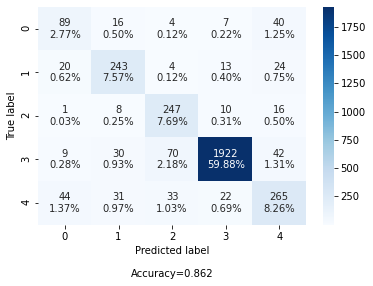

In [29]:
make_confusion_matrix(val_scores['confusion_matrix'])

In [30]:
model = context.catalog.load('model')

2020-12-08 16:00:42,027 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


In [31]:
model.eval()

LeafDoctorModel(
  (trunk): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [32]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-08 16:00:56,271 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [33]:
train_images_torch.transform = get_test_transforms()

In [37]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [39]:
def predict(model, x, invtemp=1):
    logits = model.forward(x)
    probabilities = nn.functional.softmax(invtemp*logits, dim=1)
    return probabilities

def pred_label(model, x, invtemp=1):
    return torch.max(predict(model, x, invtemp=invtemp), 1)[1]

def predict_diff_temps(model, x, invtemps):
    logits = model.forward(x)
    
    return {
        temp: nn.functional.softmax(temp*logits, dim=1) for temp in invtemps
    }


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


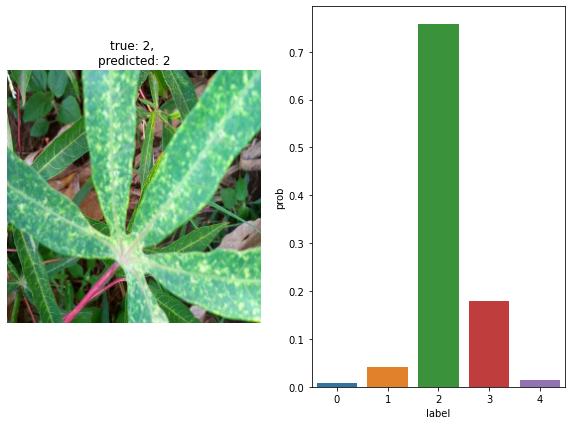

In [43]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = predict(model, image.unsqueeze(0), invtemp=0.5)[0]
prediction = pred_label(model, image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()

# Calibration curves

In [44]:
from sklearn.calibration import calibration_curve

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
from cassava.utils import DatasetFromSubset

In [46]:
indices = np.random.choice(range(len(train_images_torch)), 2000)

In [47]:
train_images_torch.transform = None

In [48]:
dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=indices),
                      transform=get_test_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [55]:
predictions = {}
true_labels = []

invtemps = [0.75, 1, 1.5, 2]

for temp in invtemps:
    predictions[temp] = []

model.eval()
for images, labels in tqdm(loader):
    preds =  predict_diff_temps(model, images, invtemps)
    for temp in invtemps:
        predictions[temp] += preds[temp].tolist()
    true_labels += labels.tolist()

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


In [56]:
for temp in invtemps:
    predictions[temp] = np.array(predictions[temp])
true_labels = np.array(true_labels)

In [57]:
true_labels[:10]

array([2, 3, 2, 1, 2, 3, 3, 3, 2, 1])

In [58]:
predictions[1][:10]

array([[5.91683893e-05, 1.33037509e-04, 3.13446783e-02, 9.68321860e-01,
        1.41269120e-04],
       [4.60899930e-04, 3.60535603e-04, 2.81346589e-02, 9.67872262e-01,
        3.17163207e-03],
       [4.85007698e-03, 1.19167687e-02, 8.15002441e-01, 1.26547769e-01,
        4.16829996e-02],
       [2.27818382e-04, 9.94545698e-01, 1.61605433e-03, 3.11787217e-03,
        4.92497580e-04],
       [5.14410716e-03, 1.18085684e-03, 9.17753756e-01, 6.93767965e-02,
        6.54451596e-03],
       [1.54546637e-04, 2.29921177e-04, 1.76839996e-02, 9.80809987e-01,
        1.12146034e-03],
       [4.57596414e-08, 6.51999062e-06, 5.73163106e-06, 9.99987602e-01,
        1.21097344e-07],
       [7.65890628e-03, 2.58150488e-01, 1.69917906e-03, 7.28856564e-01,
        3.63484677e-03],
       [3.63897346e-03, 4.67085047e-03, 8.38304758e-01, 1.32573128e-01,
        2.08123196e-02],
       [1.91683117e-02, 8.64245236e-01, 1.17865717e-02, 1.64171495e-02,
        8.83827507e-02]])

<ipython-input-59-a02fec00b023>:10: UserWarning: Attempting to set identical bottom == top == 0.877 results in singular transformations; automatically expanding.
  plt.ylim(min(accuracies), max(accuracies))


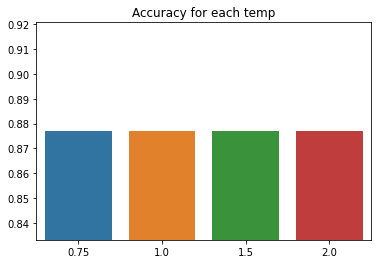

In [59]:
accuracies = []
for temp in invtemps:
    pred_probs = predictions[temp]
    pred_labels = np.argmax(pred_probs, 1)
    
    accuracies.append(accuracy_score(true_labels, pred_labels))
plt.figure()
sns.barplot(x=invtemps, y=accuracies)
plt.title('Accuracy for each temp')
plt.ylim(min(accuracies), max(accuracies))
plt.show()

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


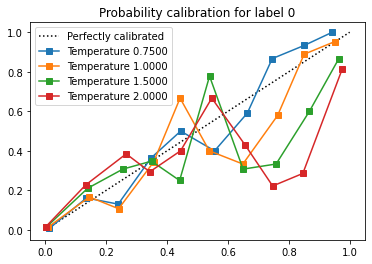

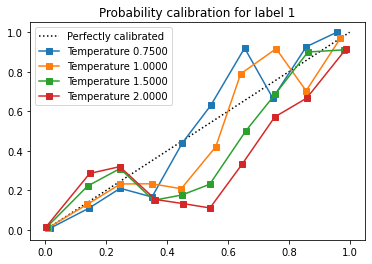

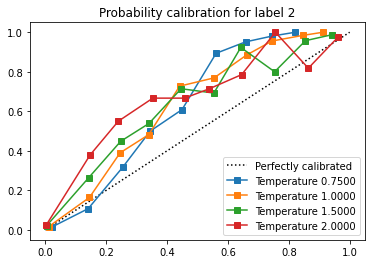

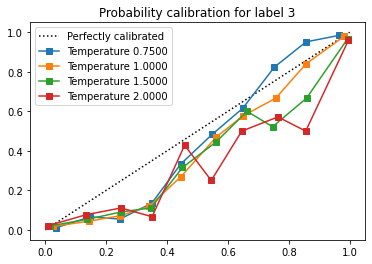

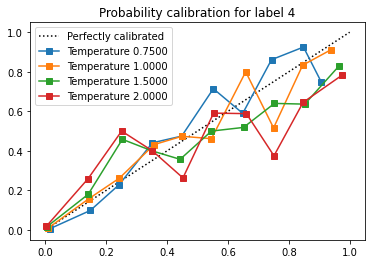

In [60]:
for label in [0, 1, 2, 3, 4]:
    plt.figure()
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title(f'Probability calibration for label {label}')
    true_label = (true_labels == label)
    
    for temp in invtemps:
        pred_prob = predictions[temp][:, label]
    
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(true_label, pred_prob, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Temperature {temp:0.4f}")
    plt.legend()
    plt.show()